<b>Zillow Scrape and data analysis </b>

The first part will run a script that will scrape and compile the housing data into csv worksheets. The default URL which is being run is for all rental properties available in Durham. Note that apartments are excluded from being saved as most of them are not available to purchase. Only townhouses and houses are saved

In [29]:
import scrapeAndCompileHousingData

In [5]:
scrapeAndCompileHousingData.main()

starting page : 0


C:\Users\Adam\Anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 184 of the file C:\Users\Adam\Anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


<div class="zsg-photo-card-content zsg-aspect-ratio-content" itemscope="" itemtype="http://schema.org/SingleFamilyResidence"><span class="hide" itemprop="address" itemscope="" itemtype="http://schema.org/PostalAddress"><span itemprop="streetAddress">7702 Morrell Ln</span><span itemprop="addressLocality">Durham</span><span itemprop="addressRegion">NC</span><span class="hide" itemprop="postalCode">27713</span></span><span itemprop="geo" itemscope="" itemtype="http://schema.org/GeoCoordinates"><meta content="35.899703" itemprop="latitude"/><meta content="-78.957286" itemprop="longitude"/></span><div class="zsg-photo-card-caption"><h4 class="zsg-photo-card-spec"><span class="zsg-photo-card-status"><span class="zsg-icon-for-rent"></span>House For Rent</span></h4><p class="zsg-photo-card-spec"><span class="zsg-photo-card-price">$2,750/mo</span><span class="zsg-photo-card-info">3 bds <span class="interpunct">·</span> 2.5 ba <span class="interpunct">·</span> 1,834 sqft</span></p><p class="zsg-

KeyboardInterrupt: 

Currently a number of csv sheets have been saved based on information using the Zillow API.

<b>Data Visualization: price</b>

In [6]:
import pandas as pd
import numpy
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pandas.stats.api import ols

In [52]:

house_data = pd.read_csv('allDurhamDataWithCoords.csv', index_col=0, thousands=',')
X = house_data[['bedrooms', 'bathrooms', 'sqft']]
house_price = house_data['zestimate']
house_rent = house_data['real rent']
house_price_rent_ratio = house_rent / house_price
house_data['rentToPrice'] = house_price_rent_ratio
house_data

,zipcode,address,latitude,longitude,zpid,bathrooms,bedrooms,sqft,homtype,taxAssessmentYear,taxAssessment,zestimate,rentzestimate,real rent,rentToPrice
city,,,,,,,,,,,,,,,
Durham,27703,511 Callandale Ln,35.959758,-78.833002,119255227,3.5,5,3255,SingleFamily,2014,47999.0,322568.0,1800,2295,0.007115
Durham,27705,2508 Richwood Rd,36.040446,-78.919083,49985222,1.0,2,760,SingleFamily,2014,75676.0,107075.0,1100,1125,0.010507
Durham,27713,8022 Morrell Ln,35.900048,-78.953188,70923894,3.0,4,2750,SingleFamily,2015,317759.0,311853.0,1895,1995,0.006397
Durham,27704,2513 State St,36.022441,-78.887781,49980939,1.0,2,969,SingleFamily,2014,66656.0,93394.0,950,1150,0.012313
Durham,27705,2029 Walnut St,36.026779,-78.926158,49984634,1.0,3,975,SingleFamily,2014,120765.0,133142.0,1150,1350,0.010140
Durham,27705,1114 9th St,36.016551,-78.921280,49966875,1.0,2,880,SingleFamily,2014,138064.0,195496.0,1250,950,0.004859
Durham,27707,3118 Hope Valley Rd,35.965036,-78.932990,49983242,2.0,3,1560,SingleFamily,2014,144120.0,209154.0,1300,1590,0.007602
Durham,27713,6 Kerr Ct,35.919690,-78.917234,50001274,2.5,3,1458,SingleFamily,2014,204192.0,226457.0,1500,1499,0.006619
Durham,27704,21 Malbry Pl,36.037257,-78.866358,50007492,2.0,3,1289,SingleFamily,2014,102096.0,117012.0,1100,1100,0.009401


In [53]:
sortedByBedrooms = [];
numBedrooms = [];
#This for loop is here to sort the bedroom data into lists based on number of bedrooms
for i in sorted(house_data.bedrooms.unique()):
    numBedrooms.append(i)
    valList = numpy.array(list(house_data.zestimate[list(house_data.bedrooms == i)]))
    valList = valList[~numpy.isnan(valList)]
    sortedByBedrooms.append(valList)
numBedrooms

[2, 3, 4, 5]

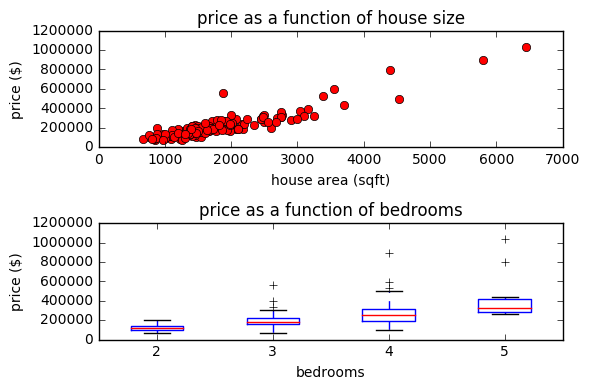

In [54]:
plt.subplot(2,1,1)
plt.plot(X['sqft'], house_price, 'ro')
plt.xlabel('house area (sqft)')
plt.ylabel('price ($)')
plt.title('price as a function of house size')
plt.subplot(2,1,2)
plt.boxplot(sortedByBedrooms)
plt.xlabel('bedrooms')
plt.ylabel('price ($)')
plt.title('price as a function of bedrooms')
plt.xticks(range(1,max(numBedrooms)), numBedrooms)
plt.tight_layout()
plt.show()

From the figures above we can see that 1 bedroom houses might need to be culled as well as the house with the way more square footage than comparable houses

In [10]:
mask = numpy.array(X['sqft']<15000) & numpy.array(X['bedrooms']>1) & numpy.array(house_price>1)

In [11]:
X = X[mask]
house_price = house_price[mask]
house_rent = house_rent[mask]
house_price_rent_ratio = house_price_rent_ratio[mask]
house_data = house_data[mask]

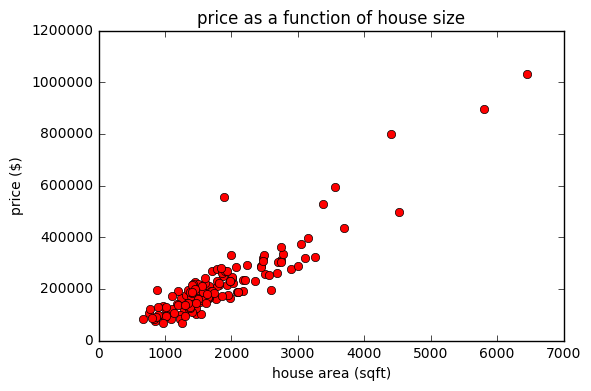

In [55]:
plt.plot(X['sqft'], house_price, 'ro')
plt.xlabel('house area (sqft)')
plt.ylabel('price ($)')
plt.title('price as a function of house size')
plt.show()

The house price per sqft looks better and more linear with outlier removed

Normalizing data before fitting a linear regression curve

In [13]:
for column_name in X.keys():
    house_data[column_name + '_norm'] = (X[column_name] - numpy.mean(X[column_name])) / numpy.std(X[column_name])

In [14]:
Xnorm = house_data[['bedrooms_norm', 'bathrooms_norm', 'sqft_norm']]

In [15]:
est = sm.OLS(house_price, Xnorm).fit()

In [16]:
est.params

bedrooms_norm     -23031.698607
bathrooms_norm      -382.321675
sqft_norm         139686.860446
dtype: float64

The results above are really weird... it would appear that house price goes down with increasing bedrooms and bathrooms. This could indicate that a large house with fewer bedrooms is worth more than a small house with more bedrooms... 

                            OLS Regression Results                            
Dep. Variable:              zestimate   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     722.6
Date:                Wed, 15 Feb 2017   Prob (F-statistic):           5.06e-59
Time:                        19:29:00   Log-Likelihood:                -1864.6
No. Observations:                 151   AIC:                             3733.
Df Residuals:                     149   BIC:                             3739.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       2.156e+05   4571.709     47.154      0.0

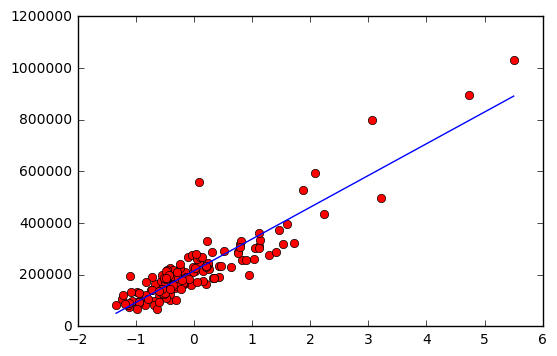

In [17]:
x = sm.add_constant(Xnorm['sqft_norm'])
estSingle = sm.OLS(house_price, x).fit()
print(estSingle.summary())
x_pred = numpy.linspace(numpy.min(Xnorm['sqft_norm']),numpy.max(Xnorm['sqft_norm']),50)
x_pred2 = sm.add_constant(x_pred)
y_pred = estSingle.predict(x_pred2)
plt.plot(Xnorm['sqft_norm'], house_price, 'ro')
plt.plot(x_pred, y_pred)
plt.show()

In [18]:
X.head()

,bedrooms,bathrooms,sqft
city,,,
Durham,5,3.5,3255
Durham,2,1.0,760
Durham,4,3.0,2750
Durham,2,1.0,969
Durham,3,1.0,975


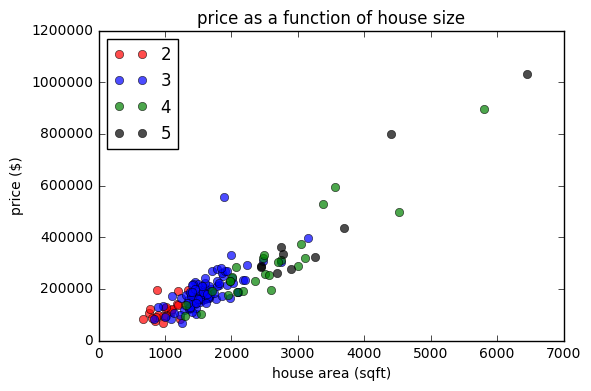

In [19]:
for i in numBedrooms:
    if i==2: 
        markColor='ro'
    elif i==3: 
        markColor='bo' 
    elif i==4: 
        markColor='go'
    elif i==5: 
        markColor='ko'
    plt.plot(X[X['bedrooms']==i]['sqft'], house_price[X['bedrooms']==i], markColor, alpha=0.7, label=str(i))
plt.legend(loc=2)
plt.xlabel('house area (sqft)')
plt.ylabel('price ($)')
plt.title('price as a function of house size')

plt.show()

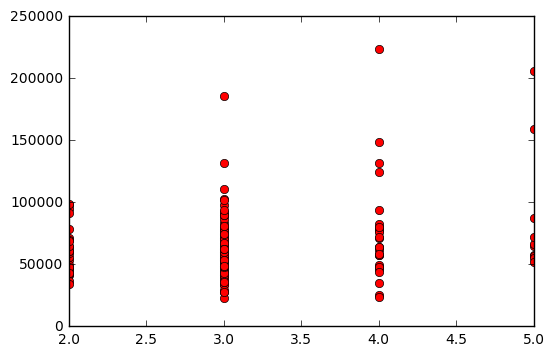

In [20]:
X['pricePerSqft']=house_price / X['bedrooms']
plt.plot(X['bedrooms'],X['pricePerSqft'], 'ro')
plt.show()

                            OLS Regression Results                            
Dep. Variable:              zestimate   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     73.00
Date:                Wed, 15 Feb 2017   Prob (F-statistic):           1.41e-14
Time:                        19:29:01   Log-Likelihood:                -1967.9
No. Observations:                 151   AIC:                             3940.
Df Residuals:                     149   BIC:                             3946.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const          2.156e+05   9058.422     23.798

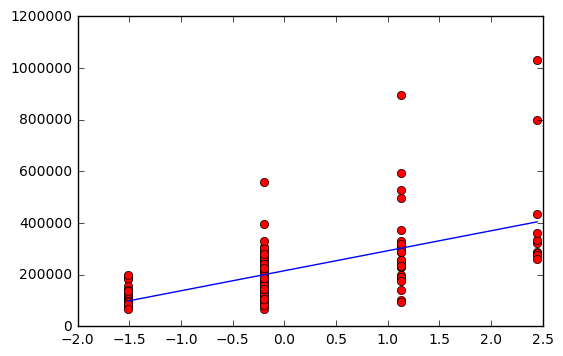

In [21]:
x = sm.add_constant(Xnorm['bedrooms_norm'])
estSingle = sm.OLS(house_price, x).fit()
print(estSingle.summary())
x_pred = numpy.linspace(numpy.min(Xnorm['bedrooms_norm']),numpy.max(Xnorm['bedrooms_norm']),50)
x_pred2 = sm.add_constant(x_pred)
y_pred = estSingle.predict(x_pred2)
plt.plot(Xnorm['bedrooms_norm'], house_price, 'ro')
plt.plot(x_pred, y_pred)
plt.show()

                            OLS Regression Results                            
Dep. Variable:              zestimate   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     41.36
Date:                Wed, 15 Feb 2017   Prob (F-statistic):           1.63e-09
Time:                        19:29:01   Log-Likelihood:                -1979.5
No. Observations:                 151   AIC:                             3963.
Df Residuals:                     149   BIC:                             3969.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
const           2.156e+05   9782.526     22.

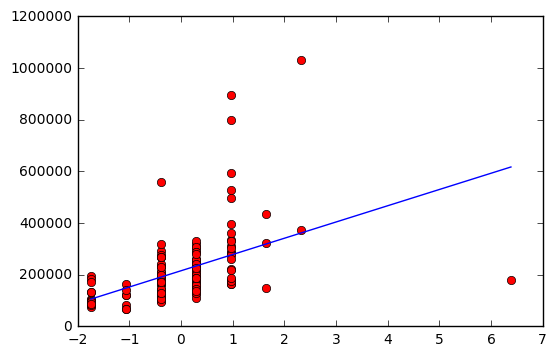

In [22]:
x = sm.add_constant(Xnorm['bathrooms_norm'])
estSingle = sm.OLS(house_price, x).fit()
print(estSingle.summary())
x_pred = numpy.linspace(numpy.min(Xnorm['bathrooms_norm']),numpy.max(Xnorm['bathrooms_norm']),50)
x_pred2 = sm.add_constant(x_pred)
y_pred = estSingle.predict(x_pred2)
plt.plot(Xnorm['bathrooms_norm'], house_price, 'ro')
plt.plot(x_pred, y_pred)
plt.show()

Above is a sanity check to ensure that each individual parameter acts as we would expect individually

<b>Data Visualization: price to rent</b>

In [56]:
sortedByBedrooms = [];
numBedrooms = [];
for i in sorted(house_data.bedrooms.unique()):
    numBedrooms.append(i)
    valList = numpy.array(list(house_price_rent_ratio[list(house_data.bedrooms == i)]))
    valList = valList[~numpy.isnan(valList)]
    sortedByBedrooms.append(valList)

In [57]:
numBedrooms

[2, 3, 4, 5]

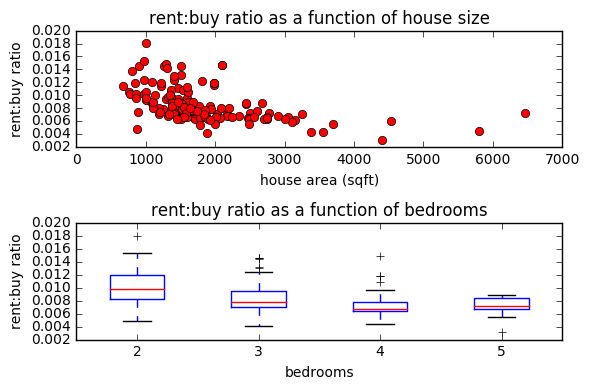

In [60]:
plt.subplot(2,1,1)
plt.plot(X['sqft'], house_price_rent_ratio, 'ro')
plt.xlabel('house area (sqft)')
plt.ylabel('rent:buy ratio')
plt.title('rent:buy ratio as a function of house size')
plt.subplot(2,1,2)
plt.boxplot(sortedByBedrooms)
plt.xticks(range(1,5), numBedrooms)
plt.xlabel('bedrooms')
plt.ylabel('rent:buy ratio')
plt.title('rent:buy ratio as a function of bedrooms')

plt.tight_layout()
plt.show()

From the figures above it seems as though we can see a weak trend that would indicate that for a rent/price ratio. It looks as though a smaller, fewer bedrooms will results in best rent returns

In [61]:
house_data = house_data.sort(columns = 'rentToPrice', ascending = False)

C:\Users\Adam\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


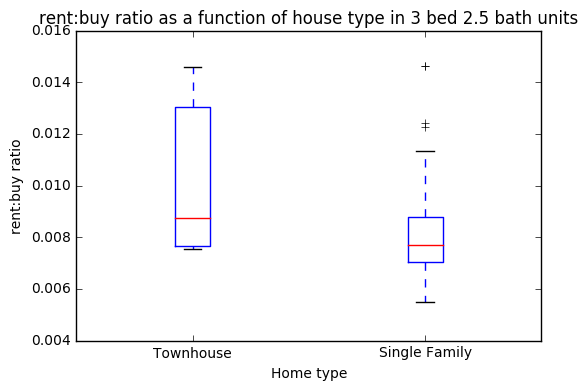

In [63]:
twoBedSingleFam = house_data[(house_data['homtype']=='SingleFamily') & (house_data['bedrooms']==3) & (house_data['bathrooms']==2.5)]
twoBedTownhouse = house_data[(house_data['homtype']=='Townhouse') & (house_data['bedrooms']==3) & (house_data['bathrooms']==2.5)]
box1 = twoBedTownhouse['rentToPrice']
box2 = twoBedSingleFam['rentToPrice']
plt.boxplot([box1, box2])
plt.xticks(range(1,3),['Townhouse', 'Single Family'])
plt.xlabel('Home type')
plt.ylabel('rent:buy ratio')
plt.title('rent:buy ratio as a function of house type in 3 bed 2.5 bath units')
plt.show()

# Here I will be attempting to apply random decision trees and forests to the data

## Decision Tree

For data to be usable by a decision tree, it must be of a categorical output. Therefore, I will change the data I have to be a 1 if it is in the upper quarter of properties and a 0 if it is in the other 3 quarters

In [70]:
len(house_data.dropna())

150

In [64]:
house_data=house_data[house_data['homtype']!='Condominium']
house_data['binaryRentToPrice']=house_data['rentToPrice']<house_data['rentToPrice'].quantile(0.75)

#townhouse is now set to 1 and single family home will be 0
house_data['homeTypeBinary']=(house_data['homtype'] == 'Townhouse').astype(int)

C:\Users\Adam\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


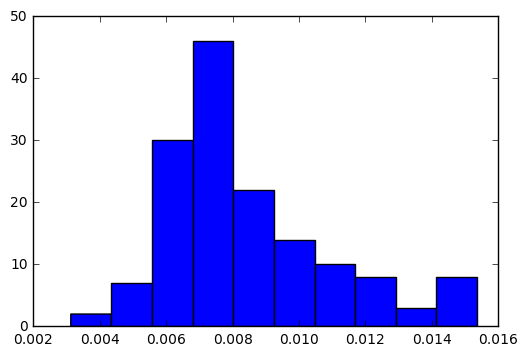

In [30]:
#seeing how rent to price ratio is distributed
plt.hist(house_data['rentToPrice'])
plt.show()

In [43]:
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import sklearn.metrics

In [179]:
feature_names=['latitude',
'longitude',
'bathrooms',
'bedrooms',
'sqft',
'homeTypeBinary']
predictors = house_data[feature_names]
targets = house_data.binaryRentToPrice

In [167]:
pred_train, pred_test, tar_train, tar_test  =   train_test_split(predictors, targets, test_size=.3, random_state=122)

In [168]:
classifier=DecisionTreeClassifier()
classifier=classifier.fit(pred_train,tar_train)
predictions=classifier.predict(pred_test)
print(sklearn.metrics.confusion_matrix(tar_test,predictions))
print(sklearn.metrics.accuracy_score(tar_test, predictions))

[[ 7  5]
 [ 6 27]]
0.755555555556


The confusion matrix above can be interpreted such that the top right corner are homes that were correctly identified as being in the top quartile for rent to price ratio, the bottom right was identified as having correctly placed homes that were not in the top 25% highest rent to price ratio in that category, the bottom left corner are false positives and the top right corner are false negatives. The accuracy score is better than random, but the confusion matrix is not exactly reassuring as we seem only slightly better than chance to correctly predict a house that is truly a good value. I think part of this has to do with my random division along the 25th percentile in a category that is continuous. I will still try to run a random forest but lasso regression may work better.

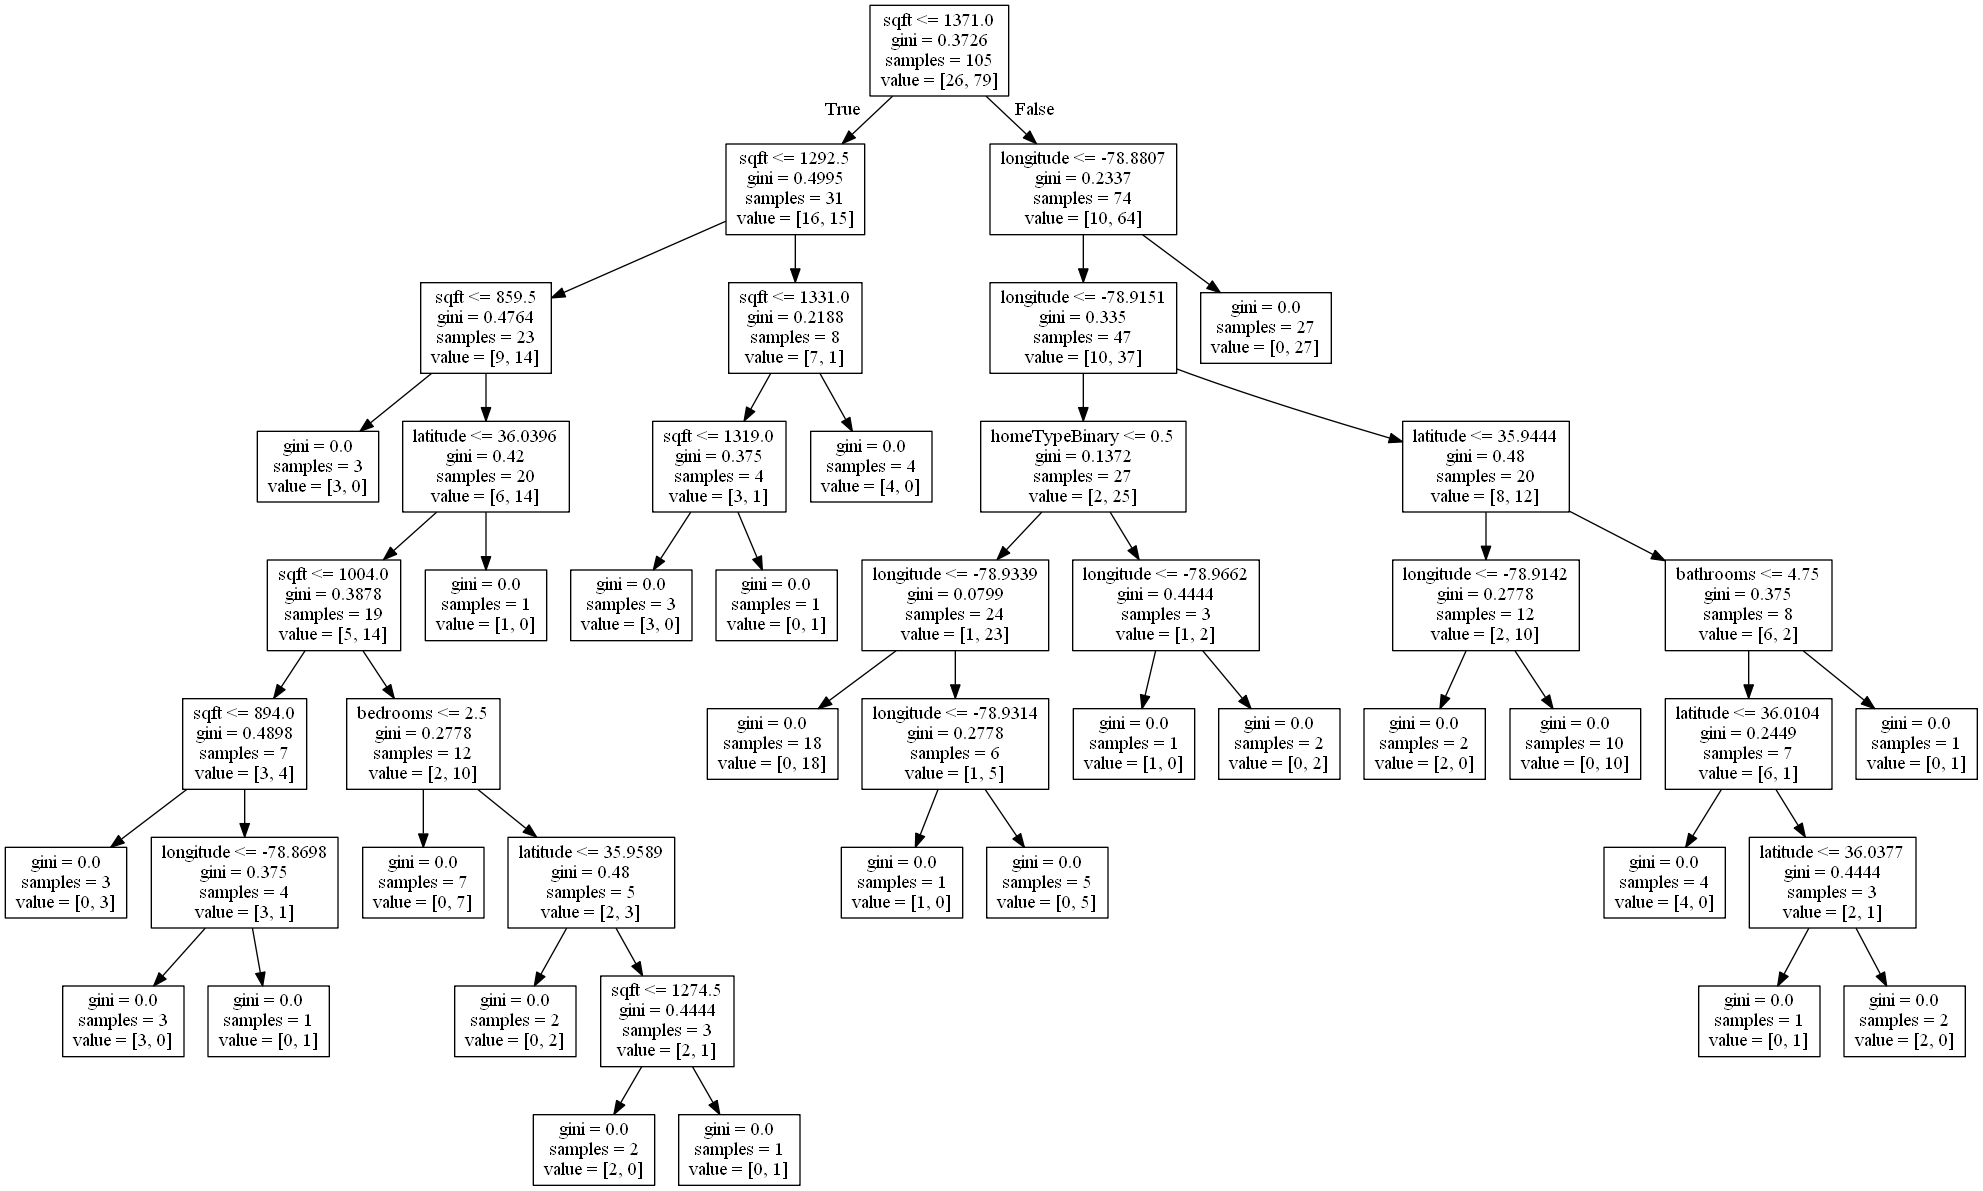

In [169]:
from sklearn import tree
#from StringIO import StringIO
from io import StringIO
#from StringIO import StringIO 
from IPython.display import Image
out = StringIO()
tree.export_graphviz(classifier, out_file=out, feature_names=feature_names)
import pydotplus
graph=pydotplus.graph_from_dot_data(out.getvalue())
Image(graph.create_png())

## Random Forest

In [172]:
from sklearn.metrics import classification_report
import sklearn.metrics
 # Feature Importance
from sklearn import datasets
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier

In [173]:
classifier=RandomForestClassifier(n_estimators=25)
classifier=classifier.fit(pred_train,tar_train)

In [175]:
predictions=classifier.predict(pred_test)

print(sklearn.metrics.confusion_matrix(tar_test,predictions))
print(sklearn.metrics.accuracy_score(tar_test, predictions))


[[ 7  5]
 [ 0 33]]
0.888888888889


No false positives! The random forest using the same data set clearly improved on the decision tree's previous performance. This is an expected and welcome result, however the complete absense of false positives means that if the algorithm tells you a place is a good investment property, it is very likely to be a good investment property. This is a pretty handy feature in the Durham housing market.

## Lasso Regression

In [40]:
from sklearn.linear_model import LassoLarsCV
from sklearn import preprocessing

In [51]:
targets = house_data.rentToPrice
predNorm=predictors.copy()
for feature in feature_names:
    predNorm[feature]=preprocessing.scale(predNorm[feature].astype('float64'))
predNorm.head()

,distanceFromCityCenter,bathrooms,bedrooms,sqft,homeTypeBinary
city,,,,,
Durham,-2.021178,-1.067600,-1.527866,-0.992276,-0.369274
Durham,-1.804715,-0.391904,1.121612,-0.606897,-0.369274
Durham,-0.147436,0.283792,-0.203127,0.343547,-0.369274
Durham,-0.143350,0.283792,-0.203127,0.343547,-0.369274
Durham,0.224751,0.283792,-0.203127,-0.365740,2.708013


In [183]:
pred_train, pred_test, tar_train, tar_test = train_test_split(predNorm, targets, 
                                                              test_size=.3, random_state=122)

In [184]:
model=LassoLarsCV(cv=10, precompute=False).fit(pred_train,tar_train)

In [185]:
dict(zip(predictors.columns, model.coef_))

{'bathrooms': -0.00014559002809431728,
 'bedrooms': 0.0,
 'homeTypeBinary': 0.00047425767165779406,
 'latitude': 0.00051622524361992137,
 'longitude': 0.00015390342708226793,
 'sqft': -0.00086749787022648555}

In [187]:
from sklearn.metrics import mean_squared_error
train_error = mean_squared_error(tar_train, model.predict(pred_train))
test_error = mean_squared_error(tar_test, model.predict(pred_test))
print ('training data MSE')
print(train_error)
print ('test data MSE')
print(test_error)
rsquared_train=model.score(pred_train,tar_train)
rsquared_test=model.score(pred_test,tar_test)
print ('training data R-square')
print(rsquared_train)
print ('test data R-square')
print(rsquared_test)

training data MSE
3.83846527301e-06
test data MSE
5.22279167445e-06
training data R-square
0.336848313132
test data R-square
0.171275931183


In [196]:
best_rent_to_price = house_data.head(int(len(house_data)/4))
worst_rent_to_price = house_data.tail(3*int(len(house_data)/4))

111

In [191]:
import codecs
fhand = codecs.open('where.js','w', "utf-8")
fhand.write("myData = [\n")
count = 0
for entry in best_rent_to_price.iterrows():
    lat = entry[1][2]
    lng = entry[1][3]
    where = entry[1][1]
    if count > 1 : fhand.write(",\n")
    output = "["+str(lat)+","+str(lng)+", '"+where+"'],"
    fhand.write(output)
    
fhand.write("\n];\n")
fhand.close()

In [197]:
import codecs
fhand = codecs.open('whereBad.js','w', "utf-8")
fhand.write("myData = [\n")
count = 0
for entry in worst_rent_to_price.iterrows():
    lat = entry[1][2]
    lng = entry[1][3]
    where = entry[1][1]
    if count > 1 : fhand.write(",\n")
    output = "["+str(lat)+","+str(lng)+", '"+where+"'],"
    fhand.write(output)
    
fhand.write("\n];\n")
fhand.close()

In [193]:
from IPython.display import display
from IPython.display import HTML
from IPython.display import IFrame
#HTML('<iframe src="./where.html" width=1000 height=1000></iframe>')
IFrame('where.html', width=700, height=500)

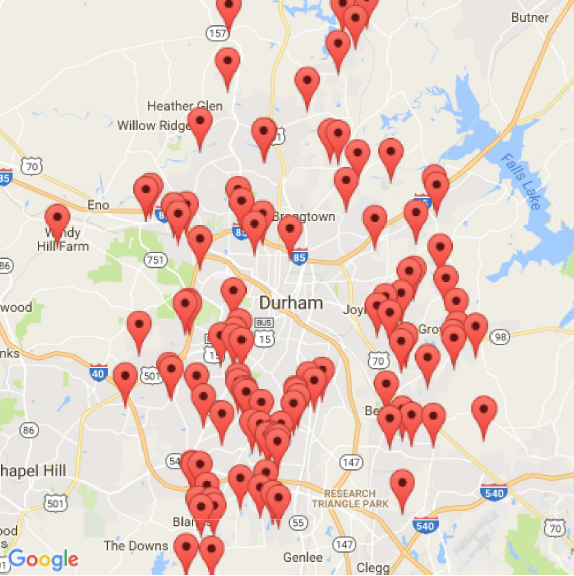

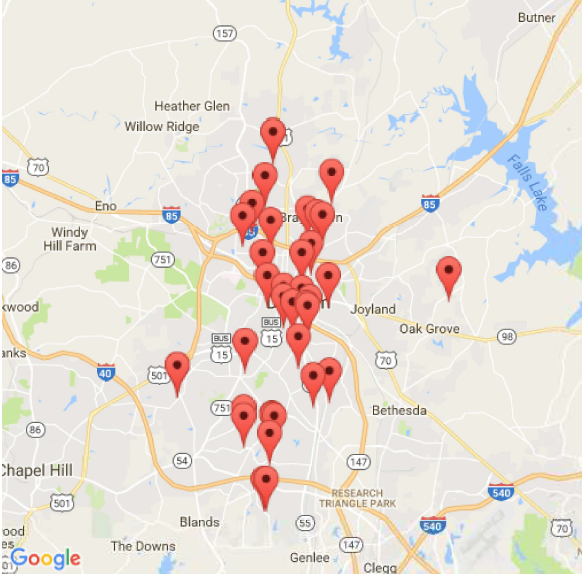

In [201]:
from IPython.display import Image
from IPython.display import display
x = Image(filename='housingMapWorst.png') 
y = Image(filename='housingMapBest.png') 
display(x, y)

We can see that the location of the house is very important in determining the investment quality of the property. However, we also see that this is a non-linear relationship and that it appears to cluster in the center of Durham. Because of this, the linear regression methods used were not very good for fitting the data. This might also explain why random forests were so good at picking out good value properties, since they are designed to find non-linear relationships.
A new parameter should be introduced. The coordinates for the center of the center of Durham by way of a google search were 35.9940° N, 78.8986° W. Based on my knowledge of the city that appears to be centered in the downtown area. A new parameter called distance to city center will be added. 

In [37]:
durhamCenterLat = 35.994043
durhamCenterLong = -78.898611
house_data['dFromCentLat'] = house_data['latitude']-durhamCenterLat
house_data['dFromCentLong'] = house_data['longitude']-durhamCenterLong
house_data['distanceFromCityCenter'] = numpy.sqrt(house_data['dFromCentLat'] ** 2 +
                                        house_data['dFromCentLong'] ** 2)
feature_names=['distanceFromCityCenter',
'bathrooms',
'bedrooms',
'sqft',
'homeTypeBinary']

In [41]:

predictors = house_data[feature_names]
targets = house_data.rentToPrice
predNorm=predictors.copy()
for feature in feature_names:
    predNorm[feature]=preprocessing.scale(predNorm[feature].astype('float64'))
predNorm.head()

,distanceFromCityCenter,bathrooms,bedrooms,sqft,homeTypeBinary
city,,,,,
Durham,-2.021178,-1.067600,-1.527866,-0.992276,-0.369274
Durham,-1.804715,-0.391904,1.121612,-0.606897,-0.369274
Durham,-0.147436,0.283792,-0.203127,0.343547,-0.369274
Durham,-0.143350,0.283792,-0.203127,0.343547,-0.369274
Durham,0.224751,0.283792,-0.203127,-0.365740,2.708013


In [45]:
pred_train, pred_test, tar_train, tar_test = train_test_split(predNorm, targets, 
                                                              test_size=.3, random_state=122)

In [46]:
model=LassoLarsCV(cv=10, precompute=False).fit(pred_train,tar_train)

In [47]:
dict(zip(predictors.columns, model.coef_))

{'bathrooms': -9.416728935543998e-05,
 'bedrooms': 0.0,
 'distanceFromCityCenter': -0.0010128240615327579,
 'homeTypeBinary': 0.0005073918641830508,
 'sqft': -0.00034506563177041396}

In [48]:
from sklearn.metrics import mean_squared_error
train_error = mean_squared_error(tar_train, model.predict(pred_train))
test_error = mean_squared_error(tar_test, model.predict(pred_test))
print ('training data MSE')
print(train_error)
print ('test data MSE')
print(test_error)
rsquared_train=model.score(pred_train,tar_train)
rsquared_test=model.score(pred_test,tar_test)
print ('training data R-square')
print(rsquared_train)
print ('test data R-square')
print(rsquared_test)

training data MSE
3.53600973358e-06
test data MSE
3.52813602505e-06
training data R-square
0.389101984041
test data R-square
0.440174637575


This is a huge improvement over the previous R-square values acheived, meaning we are seeing a stronger correlation and fitting the data much better.